# PA1
#### Applied Machine Learning
Grpup 39: Sebastian Kölbel & Min Ze Teh
## Task1
We begin by using the code provided in the assignment to transform the data in the csv file into a panda dataframe.


In [3]:
!pip install graphviz

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the CSV file.
data = pd.read_csv('Data/CTG.csv', skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)

# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]

Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

When choosing three classifiers we decided to pick one classifier form each of the different sub categories. We picked gradient boosting classifier and attempted to optimize it in terms of max depth, trying out different depths we found that we got the best performance when having a max depth of 5 or 6.

For the Multi-layer perceptron classfier we tried adjusting the hidden_layer_sizes and found that we got the best accuracy when using the input value 75.

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.linear_model import Perceptron as perc
from sklearn.neural_network import MLPClassifier as mlpc

gbc_clf = gbc(max_depth=5,random_state=1)
perc_clf = perc()
mlpc_clf = mlpc(random_state= 1, hidden_layer_sizes=75)

print('Gradient boosting classifier accuracy :', cross_val_score(gbc_clf, Xtrain, Ytrain).mean())
print('Perceptron accuracy:', cross_val_score(perc_clf, Xtrain, Ytrain).mean())
print('MLP Classifier accuracy:', cross_val_score(mlpc_clf, Xtrain, Ytrain).mean())

Gradient boosting classifier accuracy : 0.95
Perceptron accuracy: 0.825294117647059
MLP Classifier accuracy: 0.8841176470588236


For the final evaluation we picked the classifier that we found to have the best accuracy, namely the gradient boosting classifier. we fit the values and performed the prediction the resulting accuracy can be seen below.

In [6]:
from sklearn.metrics import accuracy_score

gbc_clf.fit(Xtrain, Ytrain)
Yguess = gbc_clf.predict(Xtest)
print('Gradient boosting classifier accuracy: ',accuracy_score(Ytest, Yguess))

Gradient boosting classifier accuracy:  0.931924882629108


## Task 2


We begin by copying the class' needed for the DecisionTree class. This was provided in the lectures notes.

In [7]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id

    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

In [8]:
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id

In [9]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth

    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)
        self.root = self.make_tree(X, Y, self.max_depth)

    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph

    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)

    # This is the recursive training
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))

        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)

    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]

    # The following three methods need to be implemented by the classification and regression subclasses.

    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

In [10]:
from collections import Counter

class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion

    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]

    # Checks whether a set of output values is homogeneous. In the classification case,
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1

    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

In [11]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high

def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)

def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

Then with using this newly defined class, we examine the optimal max depth for the tree using cross-validation. As well as the test accuracy using test data on the trained classifier.

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the classifier
cls = TreeClassifier(criterion='gini')

# Define the hyperparameters to tune
param_grid = {'max_depth': range(1, 11)}  # Range of max_depth values to try

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=cls, param_grid=param_grid, cv=5)
grid_search.fit(X, Y) # Using the entire set

# Get the best max_depth value
best_max_depth = grid_search.best_params_['max_depth']
print("Best max_depth:", best_max_depth)

# Train the classifier with the best max_depth value on the entire training set
best_cls = DecisionTreeClassifier(max_depth=best_max_depth, criterion='gini')
best_cls.fit(Xtrain, Ytrain)

# Evaluate the classifier on the test set
Y_pred = best_cls.predict(Xtest)
test_accuracy = accuracy_score(Ytest, Y_pred)
print("Test Accuracy:", test_accuracy)

Best max_depth: 6
Test Accuracy: 0.9061032863849765


We see here that using the best performing max_depth of 6, we get a accuracy of 91,08%.

Then by again using the TreeClassifier class we can display the tree using the draw_tree() function. If we set the max_depth to a lower number, in our case we picked 3, we can display an drawing of the decision tree that will fit in one page, which illustrates how the verdicts are constructed using thresholds and decisions.

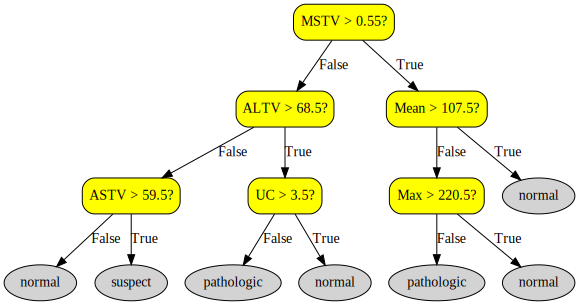

In [14]:
cls = TreeClassifier(max_depth=3, criterion='gini')
cls.fit(Xtrain, Ytrain)
cls.draw_tree()

## Task 3

In [15]:
# Read the CSV file using Pandas.
alldata = pd.read_csv('Data/sberbank.csv')

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X2 = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y2 = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain2, Xtest2, Ytrain2, Ytest2 = train_test_split(X2, Y2, test_size=0.2, random_state=0)

We attempted all suggested regressors without parameters and compared the test scores from cross validation.

In [16]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import cross_validate

dr = DummyRegressor()
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
mlpr = MLPRegressor()

models = [dr, lr, ridge, lasso, dtr, rfr, gbr, mlpr]
a = []
for x in models:
    mean = cross_validate(x, X2, Y2, scoring='neg_mean_squared_error')['test_score'].mean()
    a= np.append(a,mean)

df = pd.DataFrame(list(zip(models,a)))
print(df)

                             0             1
0             DummyRegressor()     -0.391911
1           LinearRegression()     -0.314657
2                      Ridge()     -0.314656
3                      Lasso()     -0.306771
4      DecisionTreeRegressor()     -0.548930
5      RandomForestRegressor()     -0.285353
6  GradientBoostingRegressor()     -0.265178
7               MLPRegressor() -40000.677978


From the results we decided to pick the one with the lowest negative mean squarre error, namely Gradient boosting regressor.

Now to optimize this regression model, we started off with what was familiar, looking for a max depth which would yield the best accuracy.

In [17]:
regr = GradientBoostingRegressor()

# Define the hyperparameters to tune
param_grid = {'max_depth': range(1, 11)}  # Range of max_depth values to try

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=5)
grid_search.fit(X2, Y2) # Using the entire set

# Get the best max_depth value
best_max_depth = grid_search.best_params_['max_depth']
print("Best max_depth:", best_max_depth)

Best max_depth: 5


So here we picked the max_depth of 5 based on the results of the grid search cross validation. We then continued to optimize learning rates by simply trying out different values for learning rate and using the value which gave us the best score.

In [18]:
learning_rates = [1, 0.75, 0.5, 0.25, 0.0]
a = []
for learn_r in learning_rates:
    regr_test = GradientBoostingRegressor(max_depth=5, random_state=0, learning_rate=learn_r)
    mean = cross_validate(regr_test, X2, Y2, scoring='neg_mean_squared_error')['test_score'].mean()
    a = np.append(a,mean)

df = pd.DataFrame(list(zip(learning_rates,a)))
print(df)

      0         1
0  1.00 -0.336091
1  0.75 -0.309303
2  0.50 -0.275331
3  0.25 -0.260040
4  0.00 -0.391911


A learning rate of 0.25 gave us the best score so then we looked at the n_estimators value, and again tried out different values.

In [19]:
estimators = [1, 2, 4, 8, 16, 32, 64, 128, 256]
a = []
for n_est in estimators:
    regr_test = GradientBoostingRegressor(max_depth=5, random_state=0, learning_rate=0.25, n_estimators=n_est)
    mean = cross_validate(regr_test, X2, Y2, scoring='neg_mean_squared_error')['test_score'].mean()
    a = np.append(a,mean)

df = pd.DataFrame(list(zip(estimators,a)))
print(df)

     0         1
0    1 -0.343485
1    2 -0.315292
2    4 -0.288250
3    8 -0.273365
4   16 -0.266031
5   32 -0.260609
6   64 -0.257910
7  128 -0.263326
8  256 -0.272723


The result showed that we got the best score, out of the values we attempted, using a n_estimators of 64.

We now performed the fit of the regression and calculated the mean squared error based on the predictions that the regression provided.

In [20]:
regr = GradientBoostingRegressor(max_depth=5, random_state=0, learning_rate=0.25, n_estimators=64)
regr2 = GradientBoostingRegressor(random_state=0)

In [21]:
from sklearn.metrics import mean_squared_error
regr.fit(Xtrain2, Ytrain2)
regr2.fit(Xtrain2, Ytrain2)
print('Regr mean squared error:',mean_squared_error(Ytest2, regr.predict(Xtest2)))
print('No parameters regression:',mean_squared_error(Ytest2, regr2.predict(Xtest2)))

Regr mean squared error: 0.26476194648505785
No parameters regression: 0.27136199343052597


We compared the new optimised regression to one without optimized parameters and found that we achieved a sightly better results but no big change. Perhaps there are other parameters that would bring higher levels of accuracy to our predictions. But we were not able to distinguish them.

## Task 4

We decided to reuse most of the class for the TreeClassifier, the changes we made were:
* Change ClassifierMixin to RegressorMixin
* Change the way the get_default_value calculate its value, instead of returning the most occuring value, the mean of the values were returned.
* Change the is_homogenous function to instead of looking for exact matches, use a threshold for max allowed variety. We selected the hard-coded value 0.01 to be the arbiter of homogenity.

However, the most significant changes we made were to the best_split function, where the idea is to divide the Y into two different partition, starting with the lower and empty partition and the higher partition which initially contains the full set Y. With each iteration:
* The partition shifts and one element switches partition from the higher to the lower.
* The variance of each partition is calculated with the calc_var function defined in the code cell after the TreeRegressor class. These variances are used to calculate the homogeneity of the subsets using variance reduction, also defined further down.




In [22]:
from sklearn.base import RegressorMixin

class TreeRegressor(DecisionTree, RegressorMixin):

    def __init__(self, max_depth=10, criterion='var_red'):
        super().__init__(max_depth)
        self.criterion = criterion

    def fit(self, X, Y):
        if self.criterion == 'var_red':
            self.criterion_function = variance_reduction
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most mean value.
    def get_default_value(self, Y):
        Y = np.array(Y)
        return np.mean(Y)

    # Checks whether a set of output values is homogeneous. In the regression case,
    # this means that all output values are within a certain threshold.
    def is_homogeneous(self, Y):
        Y = np.array(Y)
        return np.var(Y) <= 0.01

    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # variance for Y i.e V(S)
        total_var = calc_var(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # partition iteratively
            high_part = Y_sorted[i:]
            low_part = Y_sorted[:i]

            # Input at the current position.
            x_i = X_sorted[i]

            # Calculate variance of low and high part.
            low_var = calc_var(low_part)
            high_var = calc_var(high_part)

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_var, n-i-1, high_var, total_var)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

In [23]:
# variance_reduction function is used to measure the homogeneity of the subsets.
def variance_reduction(n_low, low_var, n_high, high_var, total_var):
    n = n_low+n_high
    return total_var - (n_high/n)*high_var - (n_low/n)*low_var

# Calcualtes variance of a set
def calc_var(Y):
    if len(Y) == 0:
        return 0
    n = len(Y)

    sum_of_sqrs_y = sum([v ** 2 for v in Y], start=1)
    sum_y = (sum(Y, start=1))
    return (1/n)*sum_of_sqrs_y - (1/n**2)*(sum_y**2)

Using the following data-generation function, a suitable decision tree to describe the data would be
# <span style="color:red">???</span>.

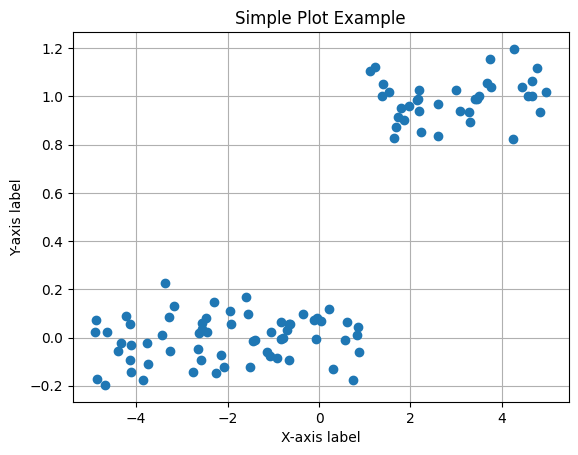

In [24]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y

X,Y = make_some_data(100)
plt.plot(X,Y,'o')
# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Simple Plot Example')
plt.grid(True)
# Show the plot
plt.show()

Mean Squared Error: 0.009937743862153294


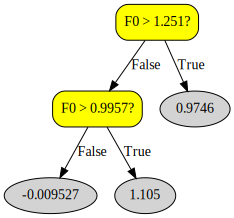

In [30]:
# Split the data into training and testing sets
Xtrain3, Xtest3, Ytrain3, Ytest3 = train_test_split(X, Y, random_state=0)

# Initialize and train your TreeRegressor
my_regr = TreeRegressor(max_depth=3, criterion='var_red')
my_regr.fit(Xtrain3, Ytrain3)

# Evaluate the model
mse = mean_squared_error(Ytest3, my_regr.predict(Xtest3))
print("Mean Squared Error:", mse)

# Draw the tree
my_regr.draw_tree()


Mean Squared Error: 0.009937743862153294


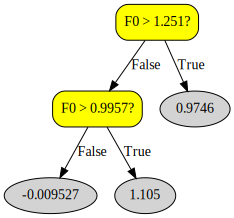

In [31]:
# Initialize and train your TreeRegressor
my_regr = TreeRegressor(max_depth=8, criterion='var_red')
my_regr.fit(Xtrain3, Ytrain3)

# Evaluate the model
mse = mean_squared_error(Ytest3, my_regr.predict(Xtest3))
print("Mean Squared Error:", mse)

# Draw the tree
my_regr.draw_tree()

In [32]:
# Read the CSV file using Pandas.
alldata = pd.read_csv('Data/sberbank.csv')

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X4 = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y4 = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain4, Xtest4, Ytrain4, Ytest4 = train_test_split(X4, Y4, test_size=0.2, random_state=0)

0.31207113610226445


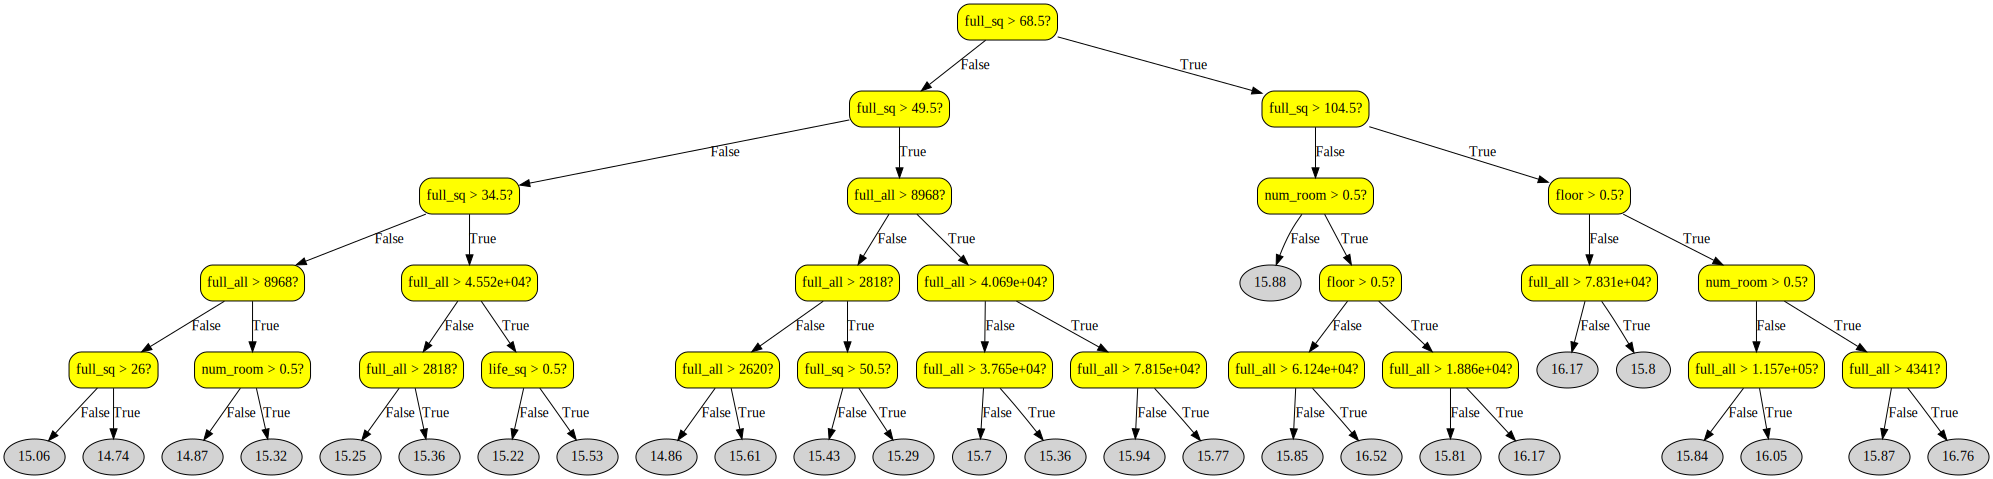

In [34]:
Xtrain4, Xtest4, Ytrain4, Ytest4 = train_test_split(X4,Y4,random_state=0)
my_regr = TreeRegressor(max_depth=5, criterion='var_red')
my_regr.fit(Xtrain4,Ytrain4)
print(mean_squared_error(Ytest4, my_regr.predict(Xtest4)))
my_regr.draw_tree()

0.30083678566172156


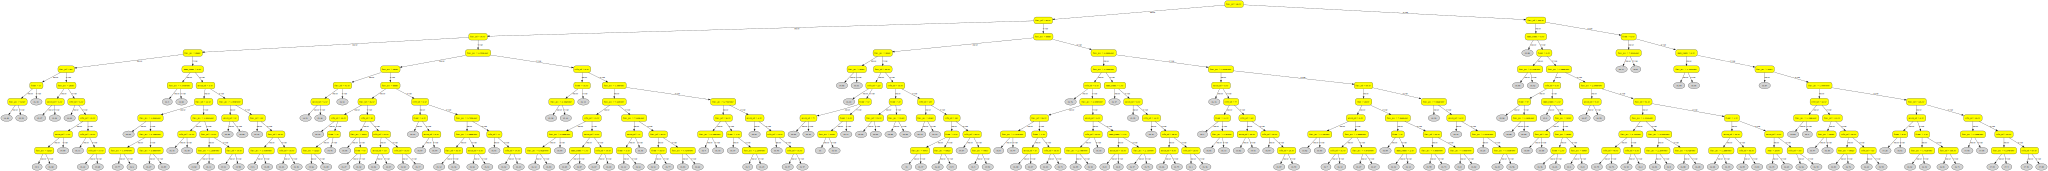

In [35]:
Xtrain4, Xtest4, Ytrain4, Ytest4 = train_test_split(X4,Y4,random_state=0)
my_regr = TreeRegressor(max_depth=10, criterion='var_red')
my_regr.fit(Xtrain4,Ytrain4)
print(mean_squared_error(Ytest4, my_regr.predict(Xtest4)))
my_regr.draw_tree()

In [36]:
mse_train = []
mse_test = []
x = np.linspace(1, 12, 11)

for i in range(1,13):
    regr = TreeRegressor(max_depth=i)
    regr.fit(Xtrain4, Ytrain4)

    # Train set
    mse_train.append(mean_squared_error(Ytrain4, regr.predict(Xtrain4)))

    # Test set
    mse_test.append(mean_squared_error(Ytest4, regr.predict(Xtest4)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, mse_train, label='MSE Train', marker='o')
plt.plot(x, mse_test, label='MSE Test', marker='o')

plt.title('MSE for Training and Testing Sets')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 